In [1]:
!pip install transformers
!pip install diffuser
!pip install accelerate

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, EulerDiscreteScheduler, UniPCMultistepScheduler
import matplotlib.pyplot as plt

In [ ]:
# Load the modules from downloaded SD 1.5 weights
vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="scheduler")

In [ ]:
device = 'cuda'
# Move the most largest three modules to GPU to run cuda.
vae.to(device)
text_encoder.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
# Set prompts and hyperparameters. 
prompt = ["a illustration poster of a anime girl",
          "a illustration poster of a anime boy"]
negPrompt=["noise,ugly,lowres,low quality,disfigured,kitsch,deformed,blurry",
           "noise,ugly,lowres,low quality,disfigured,kitsch,deformed,blurry"]
width = 512
height = 512
steps = 10
CFG = 7
random_seed = 918630
batch_size = len(prompt)

In [ ]:
# Pass POSITIVE prompt to Tokenizer
token_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt" )

# Pass POSITIVE token series to Text Encoder
with torch.no_grad():
  cond_embeddings = text_encoder(token_input.input_ids.to(device))[0]

# Shows the max_length from token_input. This should be 77. 
max_length = token_input.input_ids.shape[-1]
print(tokenizer.model_max_length)
# Shows the size of POSITIVE guidance embeddings. This value is the batch size. 
# batch size = 2 because we have two POSITIVE prompts.
# print(cond_embeddings.shape)

77


In [185]:
# Pass NEGATIVE prompt to Tokenizer
uncond_token_input = tokenizer(negPrompt, padding="max_length", max_length=max_length, return_tensors="pt")

# Pass NEGATIVE token series to Text Encoder
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_token_input.input_ids.to(device))[0]

# Shows the size of NEGATIVE guidance embeddings. Batch size = 2.
# print(uncond_embeddings.shape)

In [186]:
# Concatenate POSITIVE and NEGATVIE guidance embeddings
embeddings = torch.cat([uncond_embeddings, cond_embeddings])
print(embeddings.shape)

torch.Size([4, 77, 768])


In [ ]:
# Create latent noisy images (2 x 64w x 64h x 4ch).
generator = torch.manual_seed(random_seed)
latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
# Cache latent noise to GPU.
latents = latents.to(device)
# Amplifier a little bit for some schedulers.
latents = latents * scheduler.init_noise_sigma

C:\Users\NTUT_mrfu\AppData\Local\Temp\ipykernel_22164\2537745268.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)


In [ ]:
from tqdm.auto import tqdm

# Run denoising loops.
# Set total timesteps. 
scheduler.set_timesteps(steps)
for t in tqdm(scheduler.timesteps):
  # Duplicate the starting latent noise images for POSITIVE and NEGATIVE prompts.
  latent_model_input = torch.cat([latents]*2)
  # Scales the noisy images for a little bit. 
  latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

  with torch.no_grad():
    # Predicts the noise components for the whole 4 images (2 batch * 2 POS/NEG).
    # ebeddings are the prompt embeddings (77s x 768 dim vector)
    # Since we calls a neural network (unet) but we are not doing training task, 
    # we have to call it within no_grad().
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample

  # Split the POSITIVE(cond) and NEGATIVE(cond) preditions.
  noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
  # Do Classifier-free guidance.
  epsilon = noise_pred_uncond + CFG * ( noise_pred_cond - noise_pred_uncond)
  # Call scheduler to deduct some part of noise components from noisy latent images
  latents = scheduler.step(epsilon, t, latents).prev_sample

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Scale to match approperiate VAE input intensity.
latents = latents / 0.18215
# Call VAE to decode the latent images.T
# Again, since VAE is a neural network and we are not training, 
# so we have to wrap the call within no_grad().
with torch.no_grad():
  vae_outputs = vae.decode(latents).sample

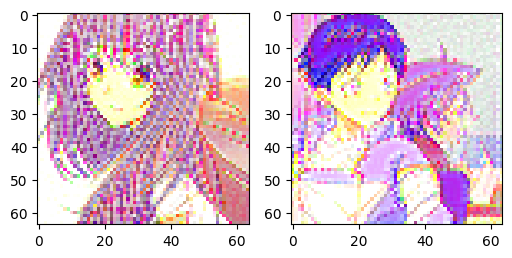

In [ ]:
# Adjust levels of latent images. 
# Note that we discard one channel of latent for RGB display.
temp = (0.18215* latents / 2 + 0.5).clamp(0,1)
temp = temp.detach().cpu().permute(0,2,3,1).numpy()
temp = (temp * 255).round().astype('uint8')

# Plot latent images. 
plt.figure(figsize=(6,3))
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.imshow(temp[i])

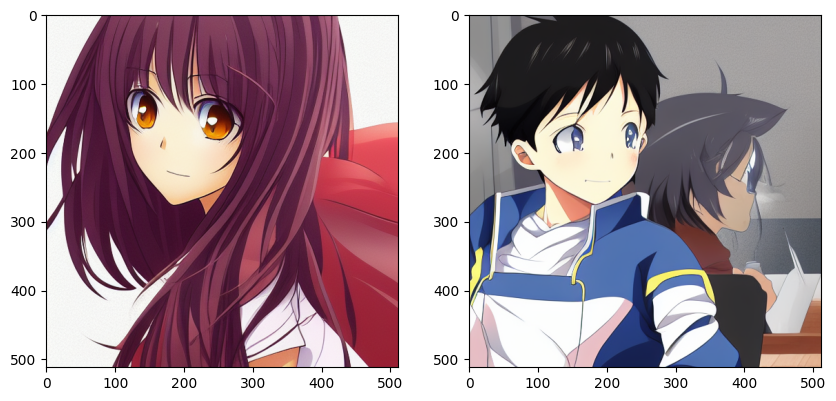

In [ ]:
# Arrange for final decoded VAE output images.
images = (vae_outputs / 2 + 0.5).clamp(0,1)
images = images.detach().cpu().permute(0,2,3,1).numpy()
images = (images * 255).round().astype('uint8')
pil_images = [Image.fromarray(image) for image in images]

# Plot final output images.
plt.figure(figsize=(10,5))
for i in range(len(prompt)):
  plt.subplot(1, len(prompt), i+1)
  plt.imshow(pil_images[i])